In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

from sklearn import preprocessing
# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

cuda


In [2]:
def create_coordinate_map(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [3]:
# create RFF features
def create_rff_features(X, num_features, gamma, random_state):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=gamma, random_state=random_state) # gamma  = 1/(2 * sigma**2)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [4]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [5]:
def plot_reconstructed_and_original_image(original_img, net, X, title="", scale=1):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples* scale**2, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height*scale, width*scale, num_channels)

    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [6]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [7]:
# Read in a image from torchvision
img = torchvision.io.read_image('dog.jpg')
print(img.shape)

torch.Size([3, 1365, 2048])


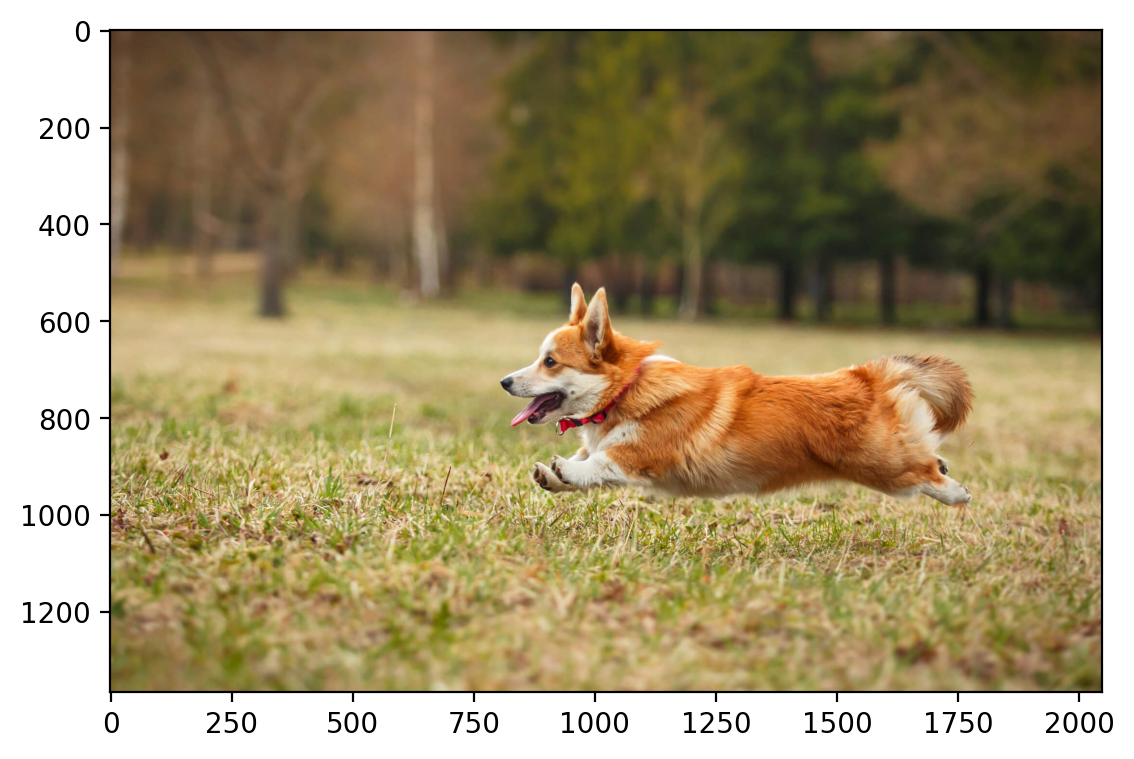

In [8]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [9]:
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled.shape, img_scaled

(torch.Size([3, 1365, 2048]),
 tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
          [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
          [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
          ...,
          [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
          [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
          [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],
 
         [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
          [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
          [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
          ...,
          [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
          [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
          [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],
 
         [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
          [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
          

torch.Size([3, 400, 400])


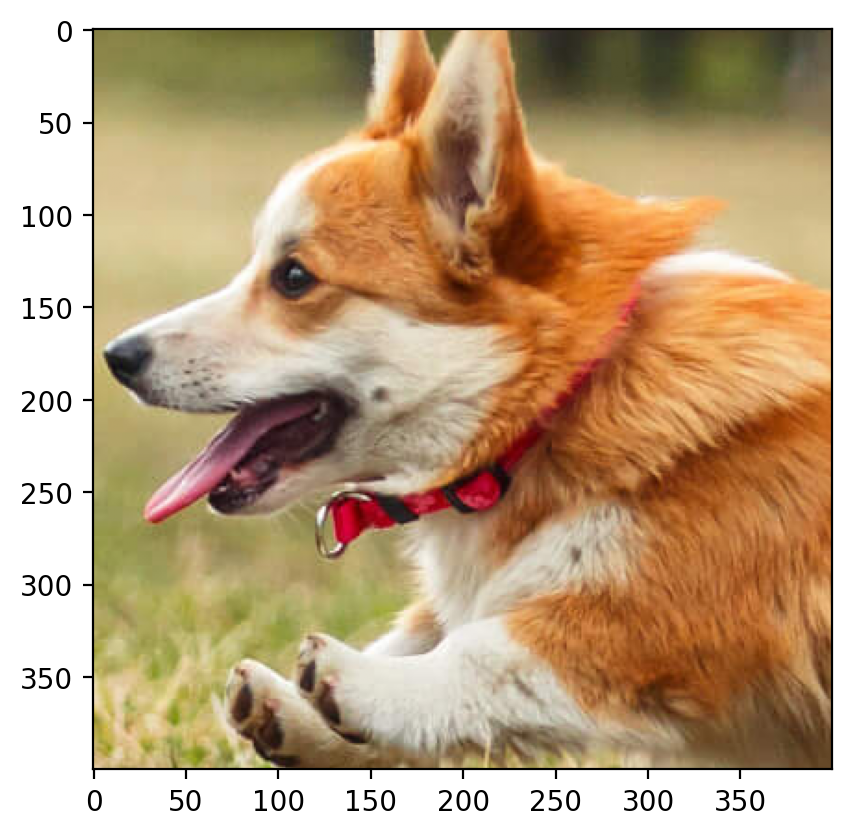

In [10]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 550, 800, 400, 400)
crop = crop.to(device)
print(crop.shape)
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

torch.Size([3, 200, 200])


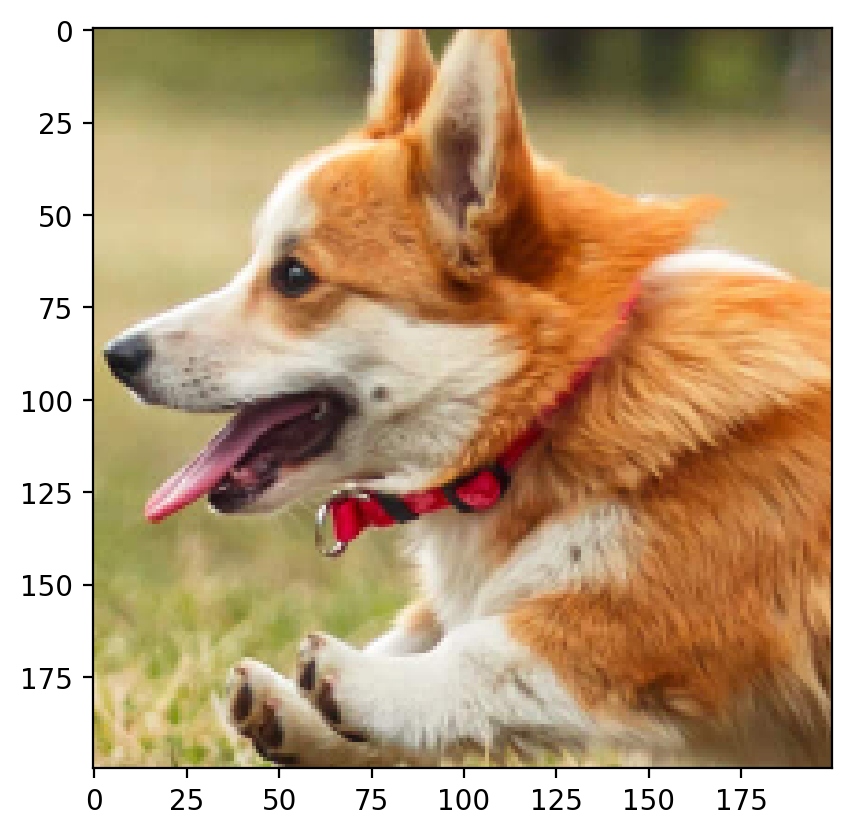

In [11]:
trans = torchvision.transforms.transforms.Resize((200,200))
resized_image = trans(crop)
resized_image = resized_image.to(device)
print(resized_image.shape)
plt.imshow(rearrange(resized_image, 'c h w -> h w c').cpu().numpy())

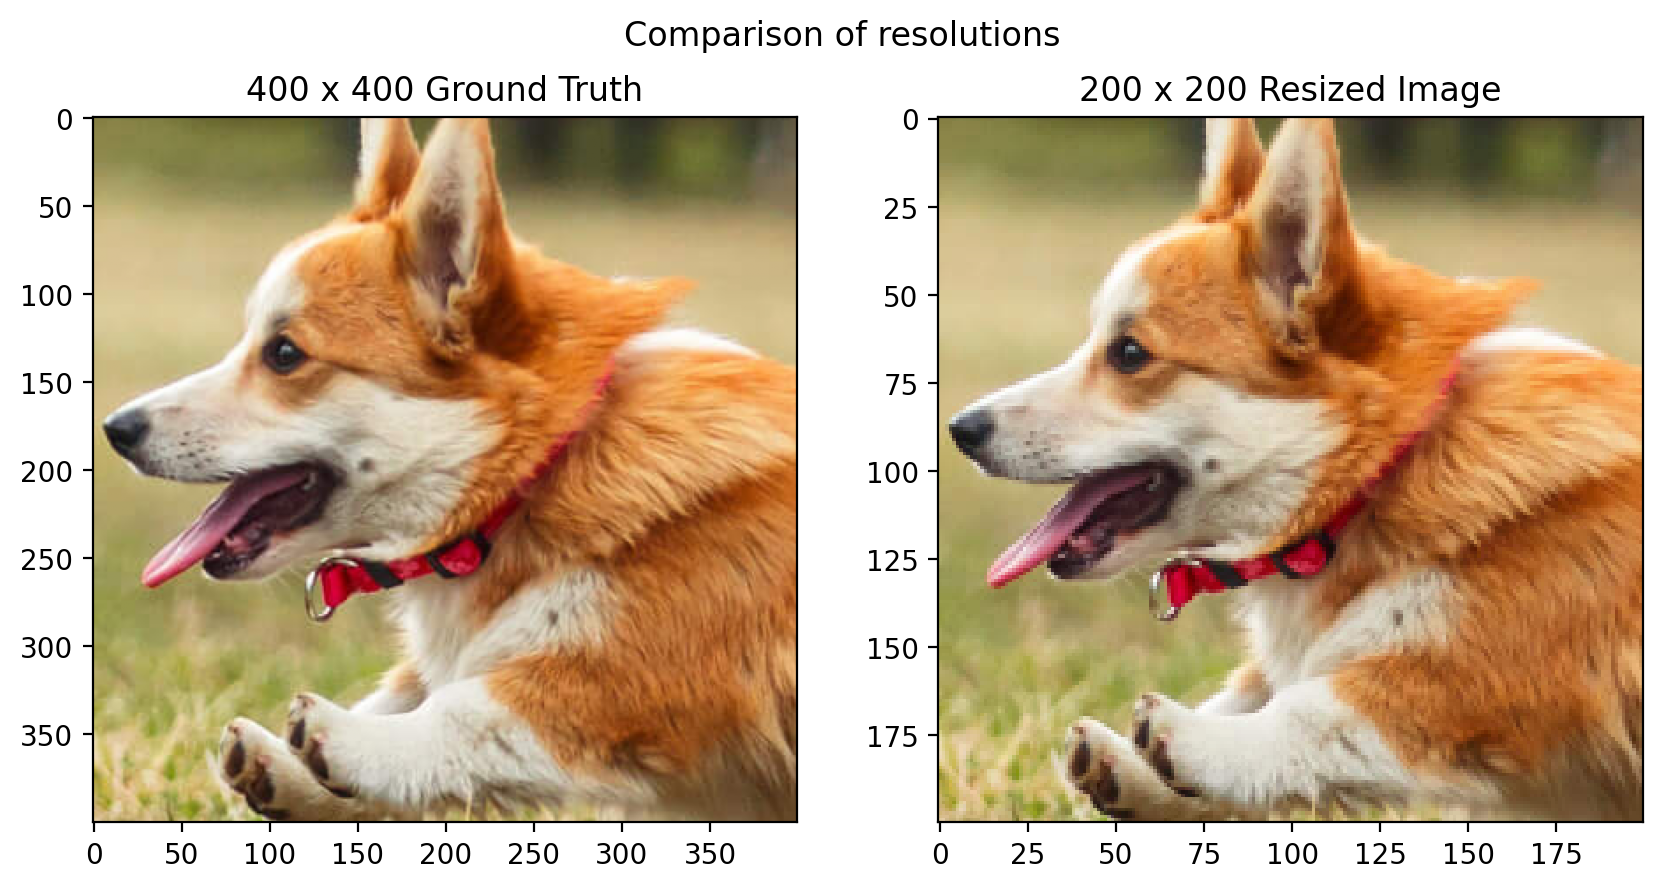

In [12]:
fig, ax = plt.subplots(1,2, figsize = (10,6))
fig.suptitle('Comparison of resolutions')
ax[0].imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
ax[0].set_title('400 x 400 Ground Truth')
ax[1].set_title('200 x 200 Resized Image')
ax[1].imshow(rearrange(resized_image, 'c h w -> h w c').cpu().numpy())
fig.subplots_adjust(top=1.1)
plt.show()

In [13]:
scale = 1
dog_X, dog_Y = create_coordinate_map(resized_image, scale=scale)
dog_X.shape, dog_Y.shape

(torch.Size([40000, 2]), torch.Size([40000, 3]))

In [14]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu()) # MinMaxScaler on dog_X from -1 to 1
dog_X_scaled = scaler_X.transform(dog_X.cpu()) # Scale the coordinates
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)
dog_X_scaled = dog_X_scaled.float()
dog_X_scaled.shape, dog_X_scaled[:10, :] # First 10 entries of dog_X scaled by MinMaxScaler from -1 to 1

(torch.Size([40000, 2]),
 tensor([[-1.0000, -1.0000],
         [-1.0000, -0.9899],
         [-1.0000, -0.9799],
         [-1.0000, -0.9698],
         [-1.0000, -0.9598],
         [-1.0000, -0.9497],
         [-1.0000, -0.9397],
         [-1.0000, -0.9296],
         [-1.0000, -0.9196],
         [-1.0000, -0.9095]], device='cuda:0'))

In [15]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features): # Neural Network has "in_features" number of input features and "out_features" number of output features.
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [39]:
X_rff = create_rff_features(dog_X_scaled, 25000, 100, random_state = 42) # num_of_features = 37500, gamma = 0.008

In [40]:
X_rff, X_rff.shape

(tensor([[ 0.0089, -0.0067,  0.0075,  ...,  0.0089,  0.0076,  0.0049],
         [ 0.0089, -0.0067,  0.0075,  ...,  0.0089,  0.0076,  0.0049],
         [ 0.0089, -0.0067,  0.0075,  ...,  0.0089,  0.0076,  0.0049],
         ...,
         [ 0.0089, -0.0065,  0.0078,  ...,  0.0085,  0.0085,  0.0073],
         [ 0.0089, -0.0065,  0.0078,  ...,  0.0085,  0.0085,  0.0073],
         [ 0.0089, -0.0065,  0.0078,  ...,  0.0085,  0.0085,  0.0074]],
        device='cuda:0'),
 torch.Size([40000, 25000]))

In [41]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=25000, out_features=3, bias=True)
)

In [42]:
train(net, 0.001, X_rff, dog_Y, 2500)

Epoch 0 loss: 0.346480
Epoch 100 loss: 0.036905
Epoch 200 loss: 0.036888
Epoch 300 loss: 0.036879
Epoch 400 loss: 0.036868
Epoch 500 loss: 0.036856
Epoch 600 loss: 0.036842
Epoch 700 loss: 0.036827
Epoch 800 loss: 0.036810
Epoch 900 loss: 0.036792
Epoch 1000 loss: 0.036773
Epoch 1100 loss: 0.036753
Epoch 1200 loss: 0.036732
Epoch 1300 loss: 0.036709
Epoch 1400 loss: 0.036686
Epoch 1500 loss: 0.036661
Epoch 1600 loss: 0.036636
Epoch 1700 loss: 0.036609
Epoch 1800 loss: 0.036582
Epoch 1900 loss: 0.036554
Epoch 2000 loss: 0.036526
Epoch 2100 loss: 0.036496
Epoch 2200 loss: 0.036466
Epoch 2300 loss: 0.036435
Epoch 2400 loss: 0.036404


0.036372553557157516

In [43]:
torch.cuda.empty_cache()

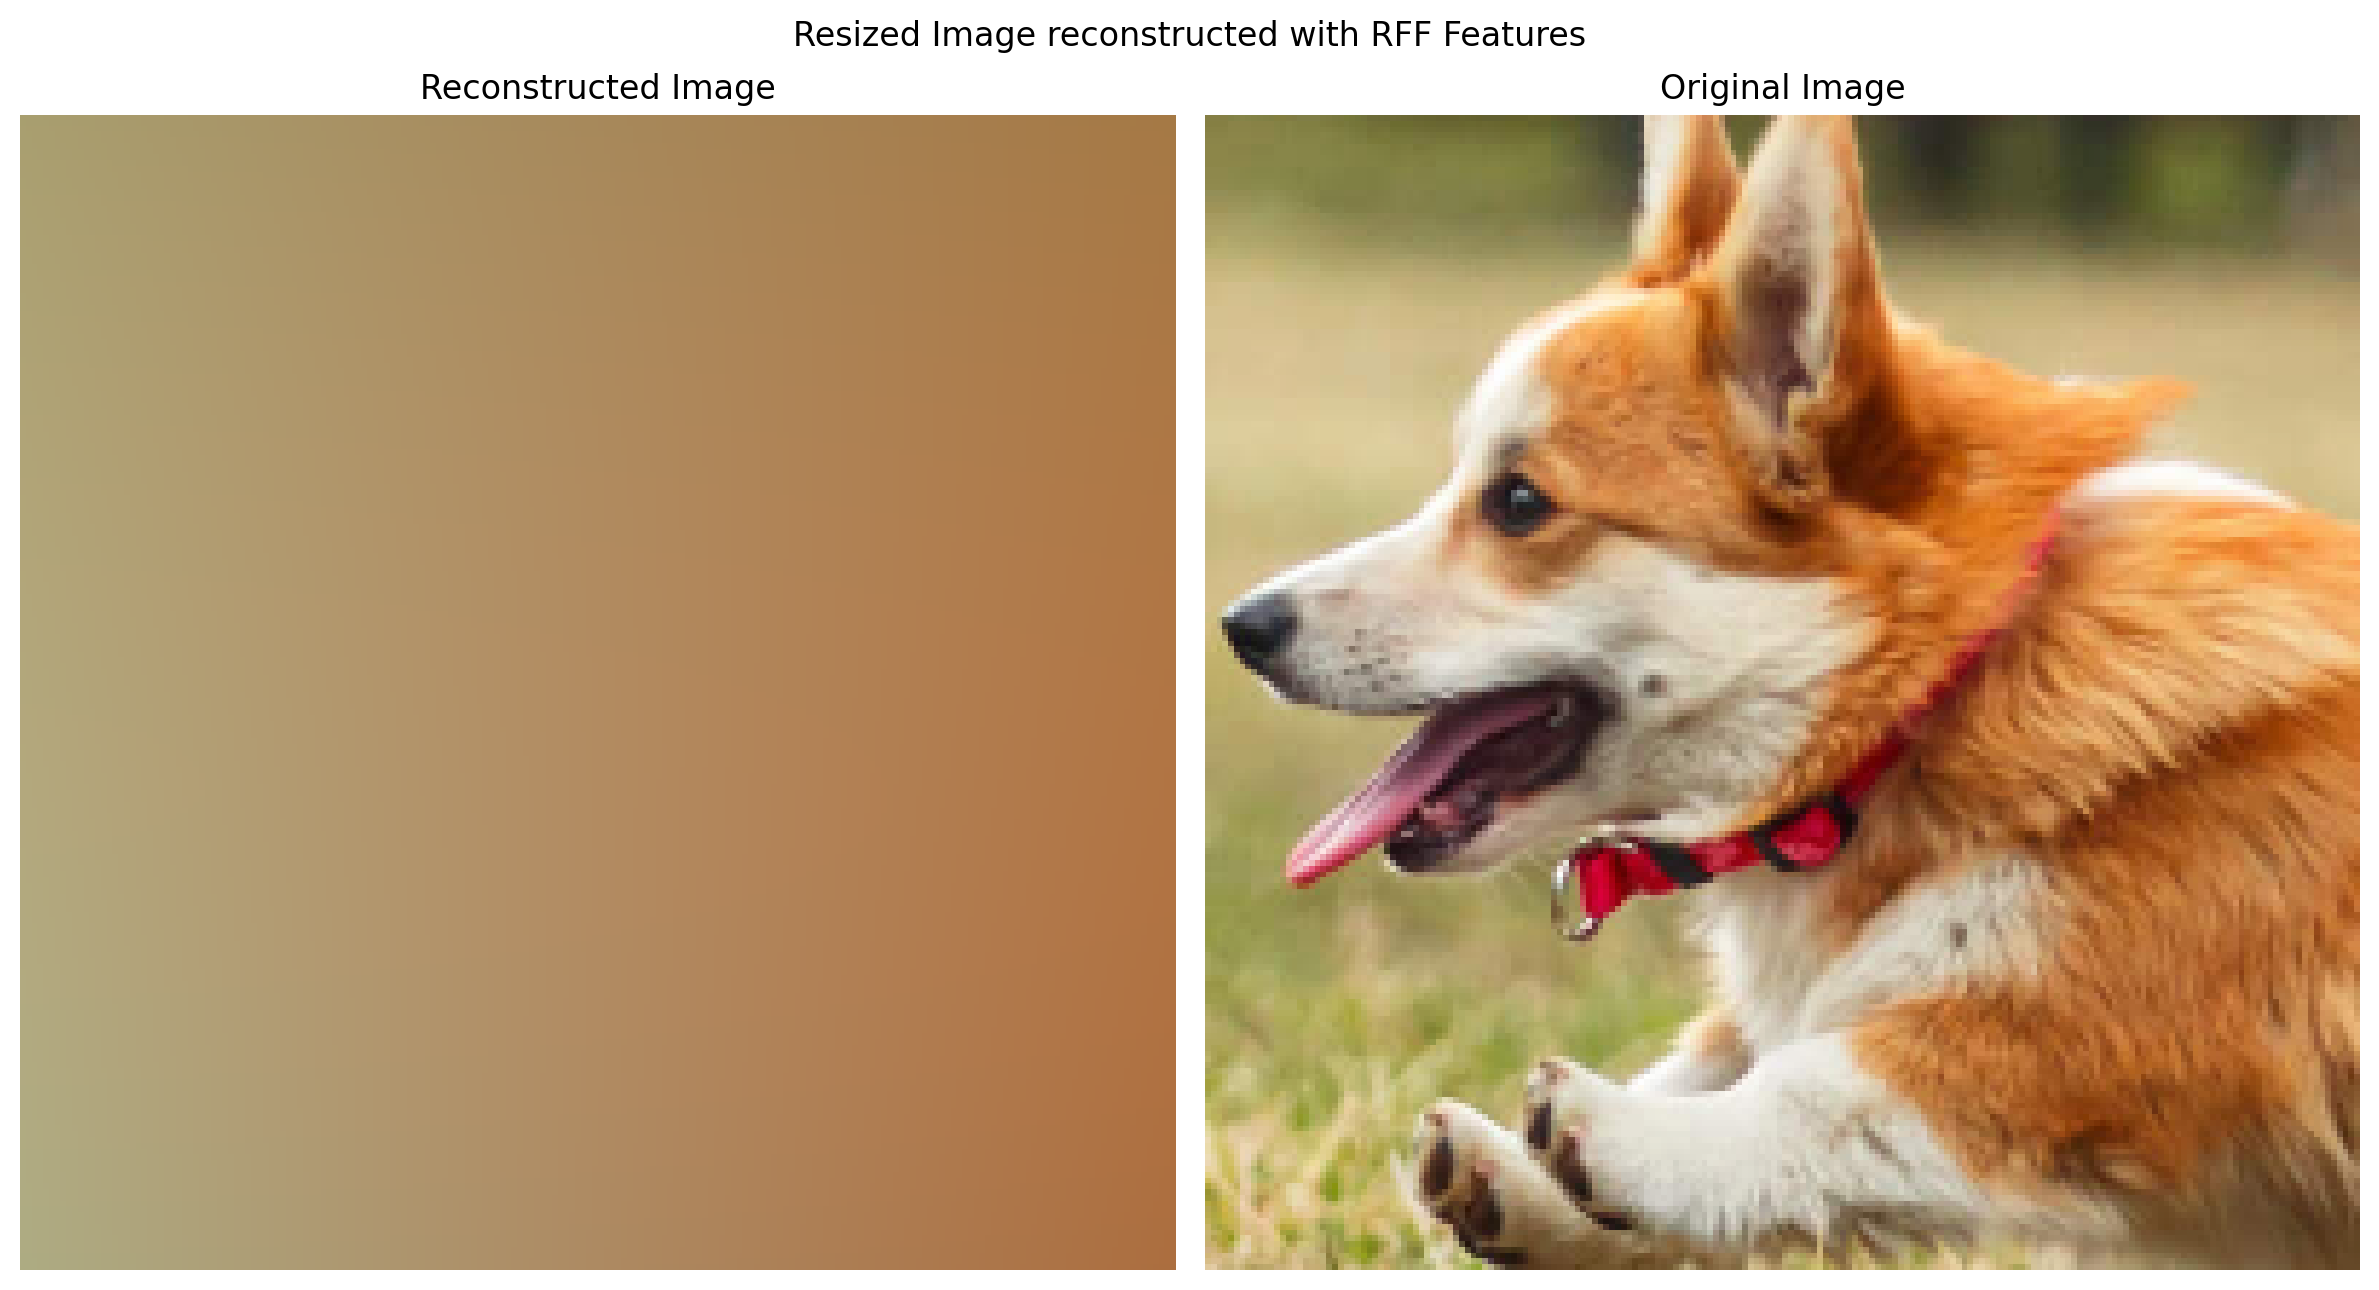

In [44]:
plot_reconstructed_and_original_image(resized_image, net, X_rff,'Resized Image reconstructed with RFF Features', scale=1)

Epoch 0 loss: 0.342018
Epoch 100 loss: 0.189640
Epoch 200 loss: 0.107109
Epoch 300 loss: 0.059528
Epoch 400 loss: 0.032567
Epoch 500 loss: 0.017650
Epoch 600 loss: 0.009588
Epoch 700 loss: 0.005327
Epoch 800 loss: 0.003126
Epoch 900 loss: 0.002012
Epoch 1000 loss: 0.001459
Epoch 1100 loss: 0.001189
Epoch 1200 loss: 0.001059
Epoch 1300 loss: 0.000996
Epoch 1400 loss: 0.000965
Epoch 1500 loss: 0.000948
Epoch 1600 loss: 0.000938
Epoch 1700 loss: 0.000931
Epoch 1800 loss: 0.000926
Epoch 1900 loss: 0.000921
Epoch 2000 loss: 0.000917
Epoch 2100 loss: 0.000914
Epoch 2200 loss: 0.000910
Epoch 2300 loss: 0.000908
Epoch 2400 loss: 0.000905


Epoch 0 loss: 0.345995
Epoch 100 loss: 0.205178
Epoch 200 loss: 0.122787
Epoch 300 loss: 0.072279
Epoch 400 loss: 0.041848
Epoch 500 loss: 0.023924
Epoch 600 loss: 0.013605
Epoch 700 loss: 0.007795
Epoch 800 loss: 0.004585
Epoch 900 loss: 0.002835
Epoch 1000 loss: 0.001885
Epoch 1100 loss: 0.001367
Epoch 1200 loss: 0.001082
Epoch 1300 loss: 0.000922
Epoch 1400 loss: 0.000831
Epoch 1500 loss: 0.000778
Epoch 1600 loss: 0.000747
Epoch 1700 loss: 0.000729
Epoch 1800 loss: 0.000717
Epoch 1900 loss: 0.000710
Epoch 2000 loss: 0.000705
Epoch 2100 loss: 0.000701
Epoch 2200 loss: 0.000698
Epoch 2300 loss: 0.000696
Epoch 2400 loss: 0.000693


Epoch 0 loss: 0.344106
Epoch 100 loss: 0.210938
Epoch 200 loss: 0.129606
Epoch 300 loss: 0.078279
Epoch 400 loss: 0.046480
Epoch 500 loss: 0.027212
Epoch 600 loss: 0.015791
Epoch 700 loss: 0.009165
Epoch 800 loss: 0.005395
Epoch 900 loss: 0.003284
Epoch 1000 loss: 0.002114
Epoch 1100 loss: 0.001465
Epoch 1200 loss: 0.001102
Epoch 1300 loss: 0.000894
Epoch 1400 loss: 0.000773
Epoch 1500 loss: 0.000699
Epoch 1600 loss: 0.000654
Epoch 1700 loss: 0.000625
Epoch 1800 loss: 0.000607
Epoch 1900 loss: 0.000595
Epoch 2000 loss: 0.000587
Epoch 2100 loss: 0.000581
Epoch 2200 loss: 0.000577
Epoch 2300 loss: 0.000574
Epoch 2400 loss: 0.000572


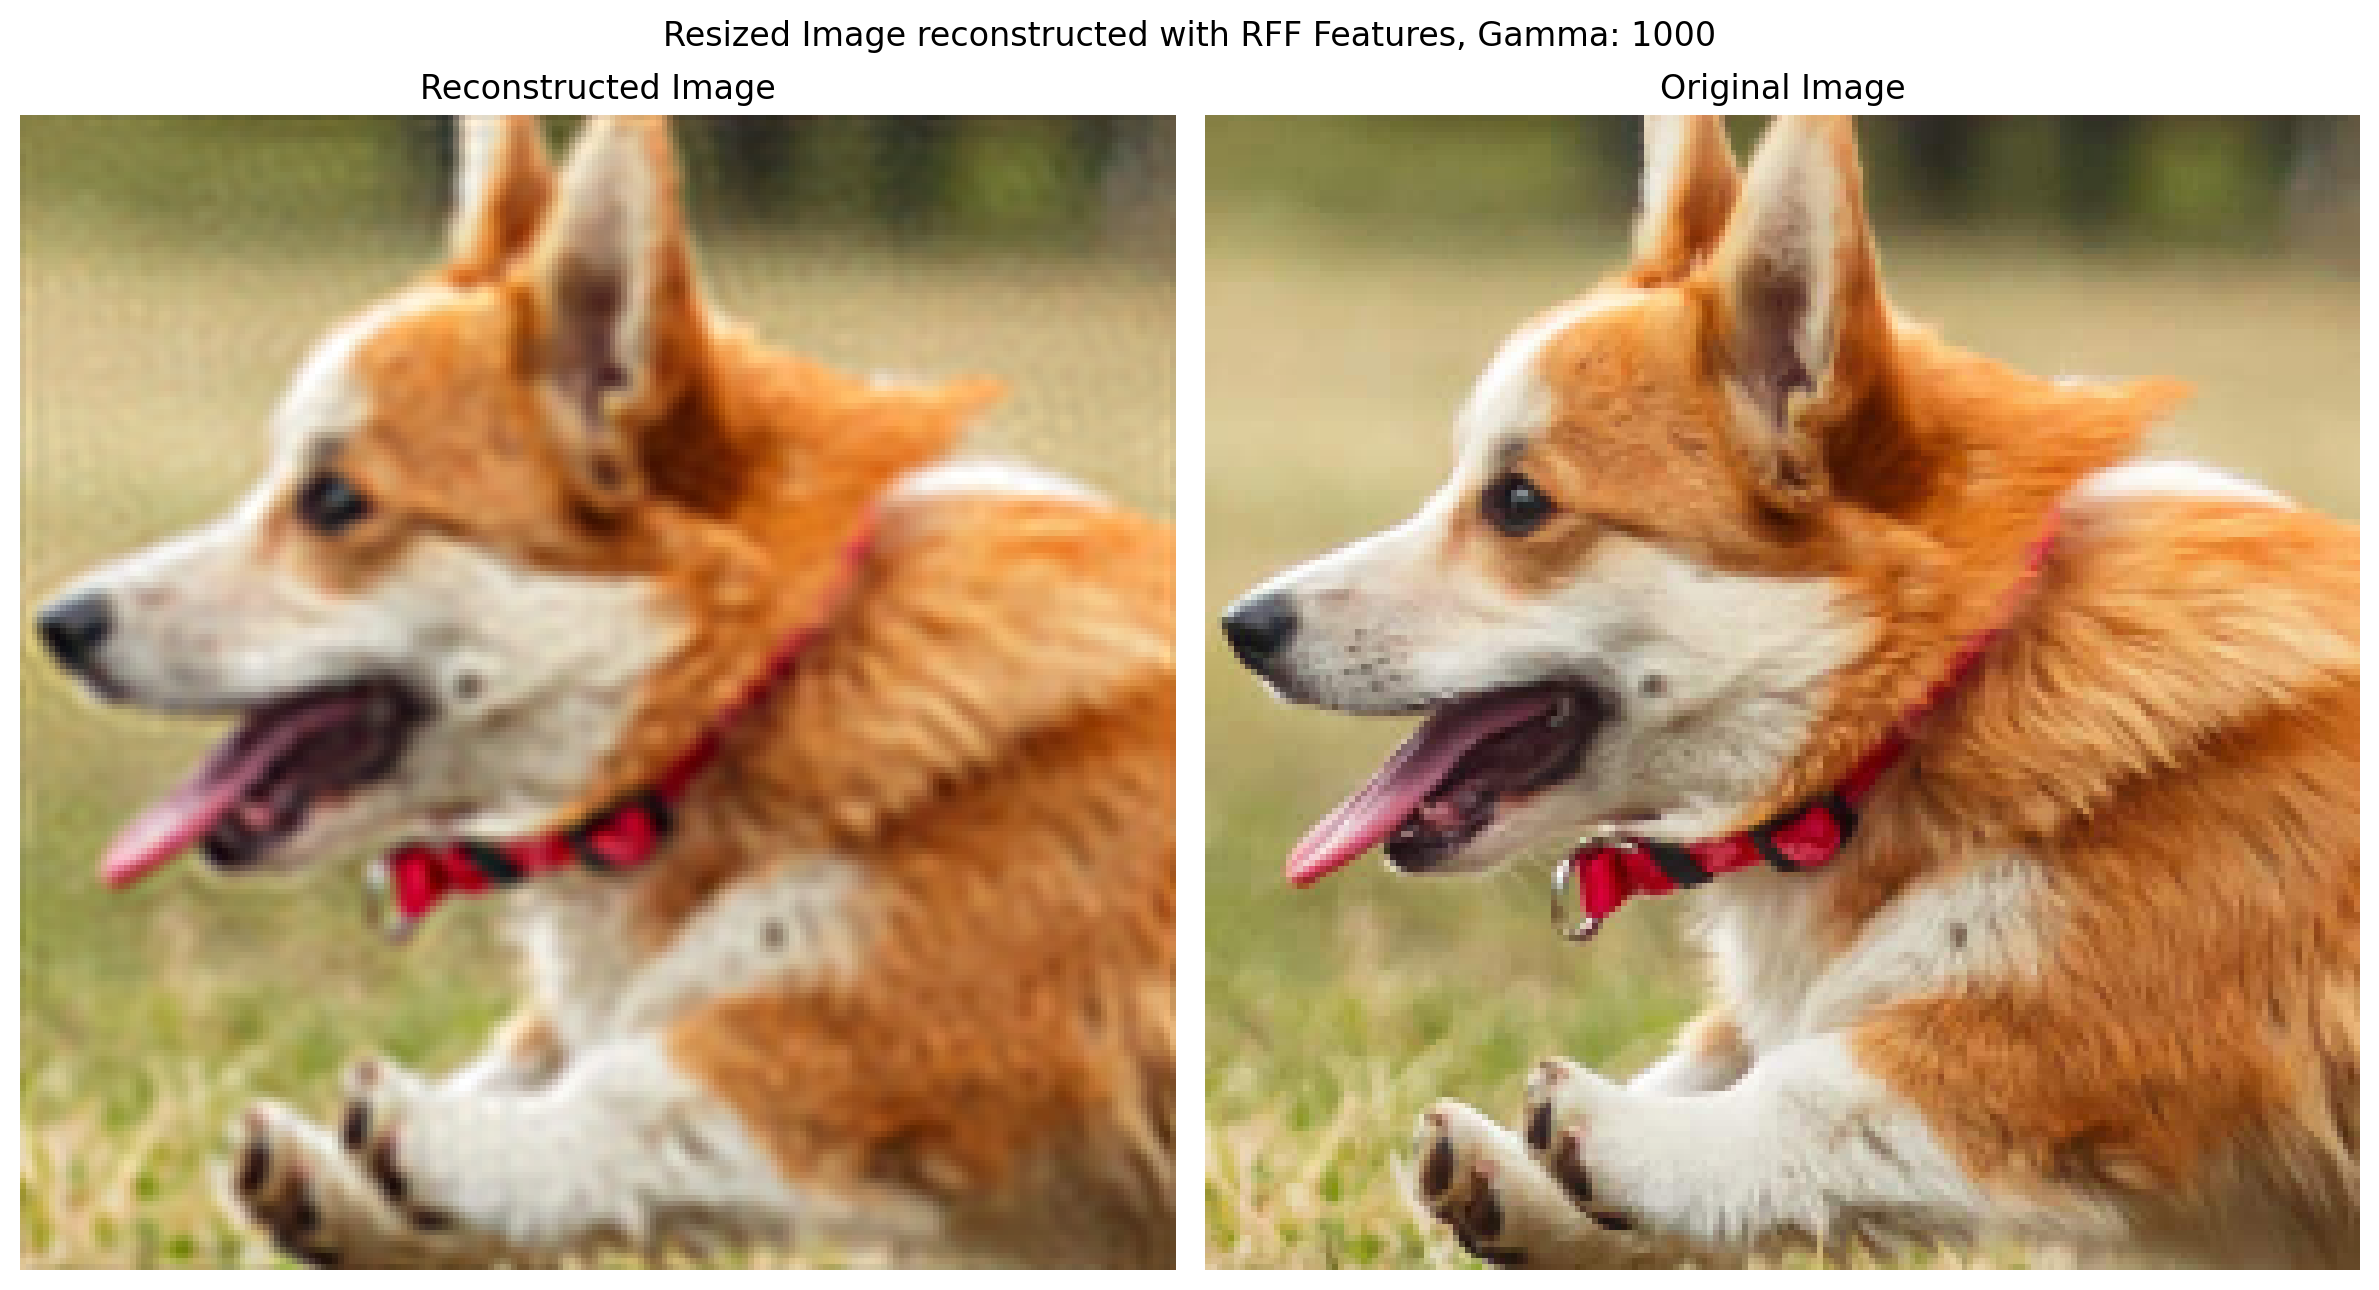

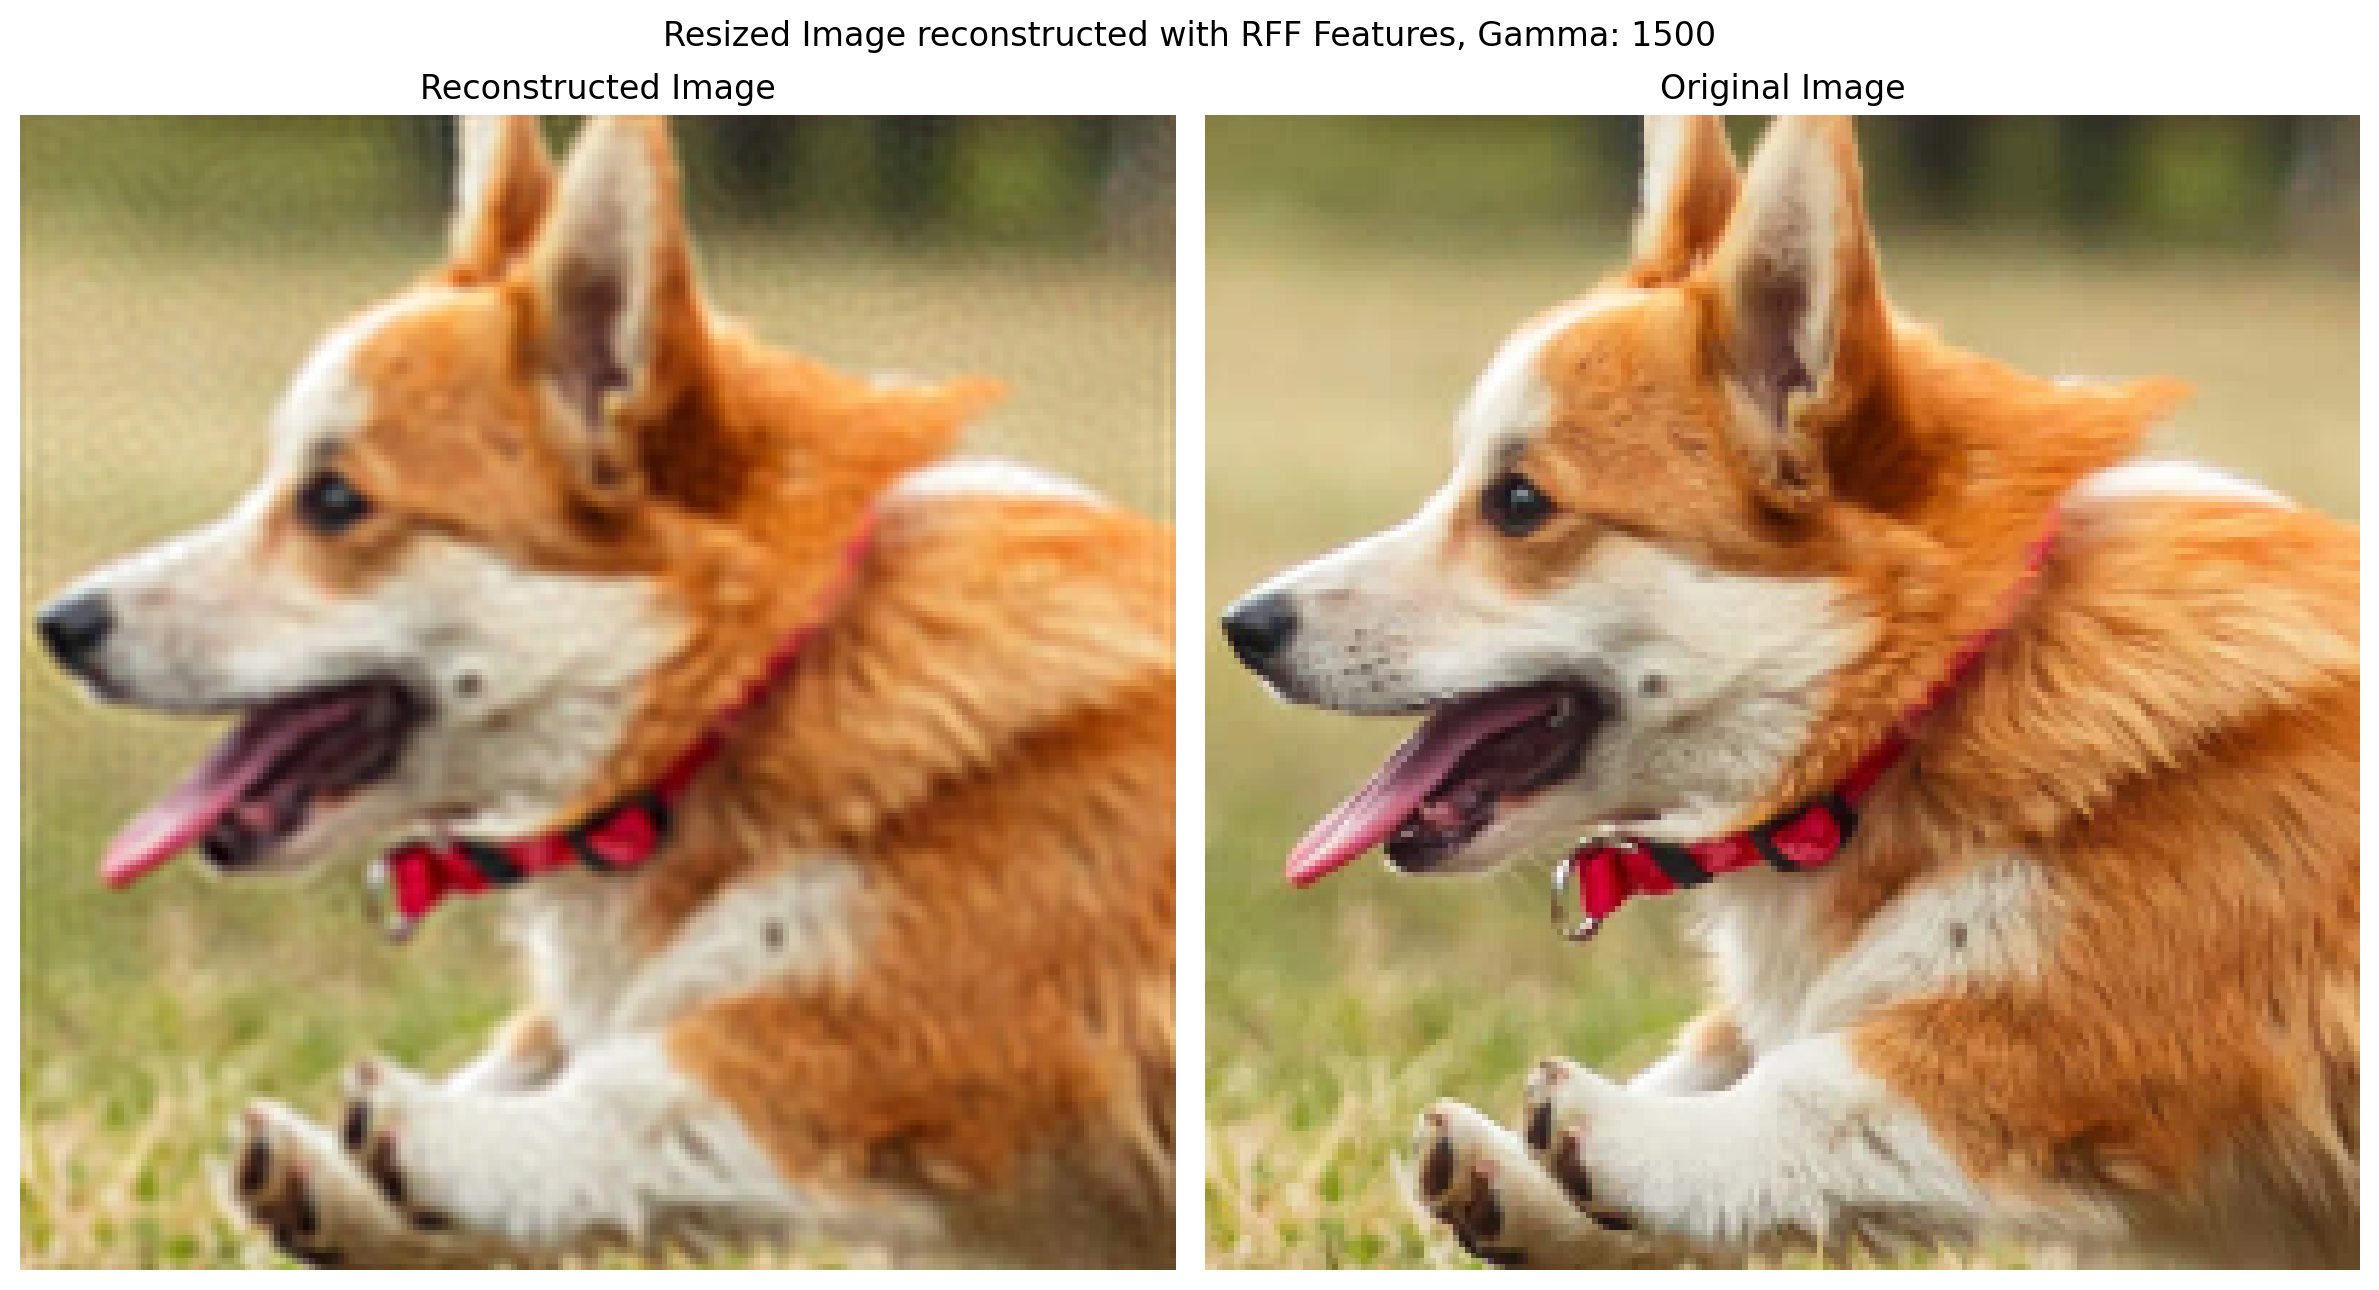

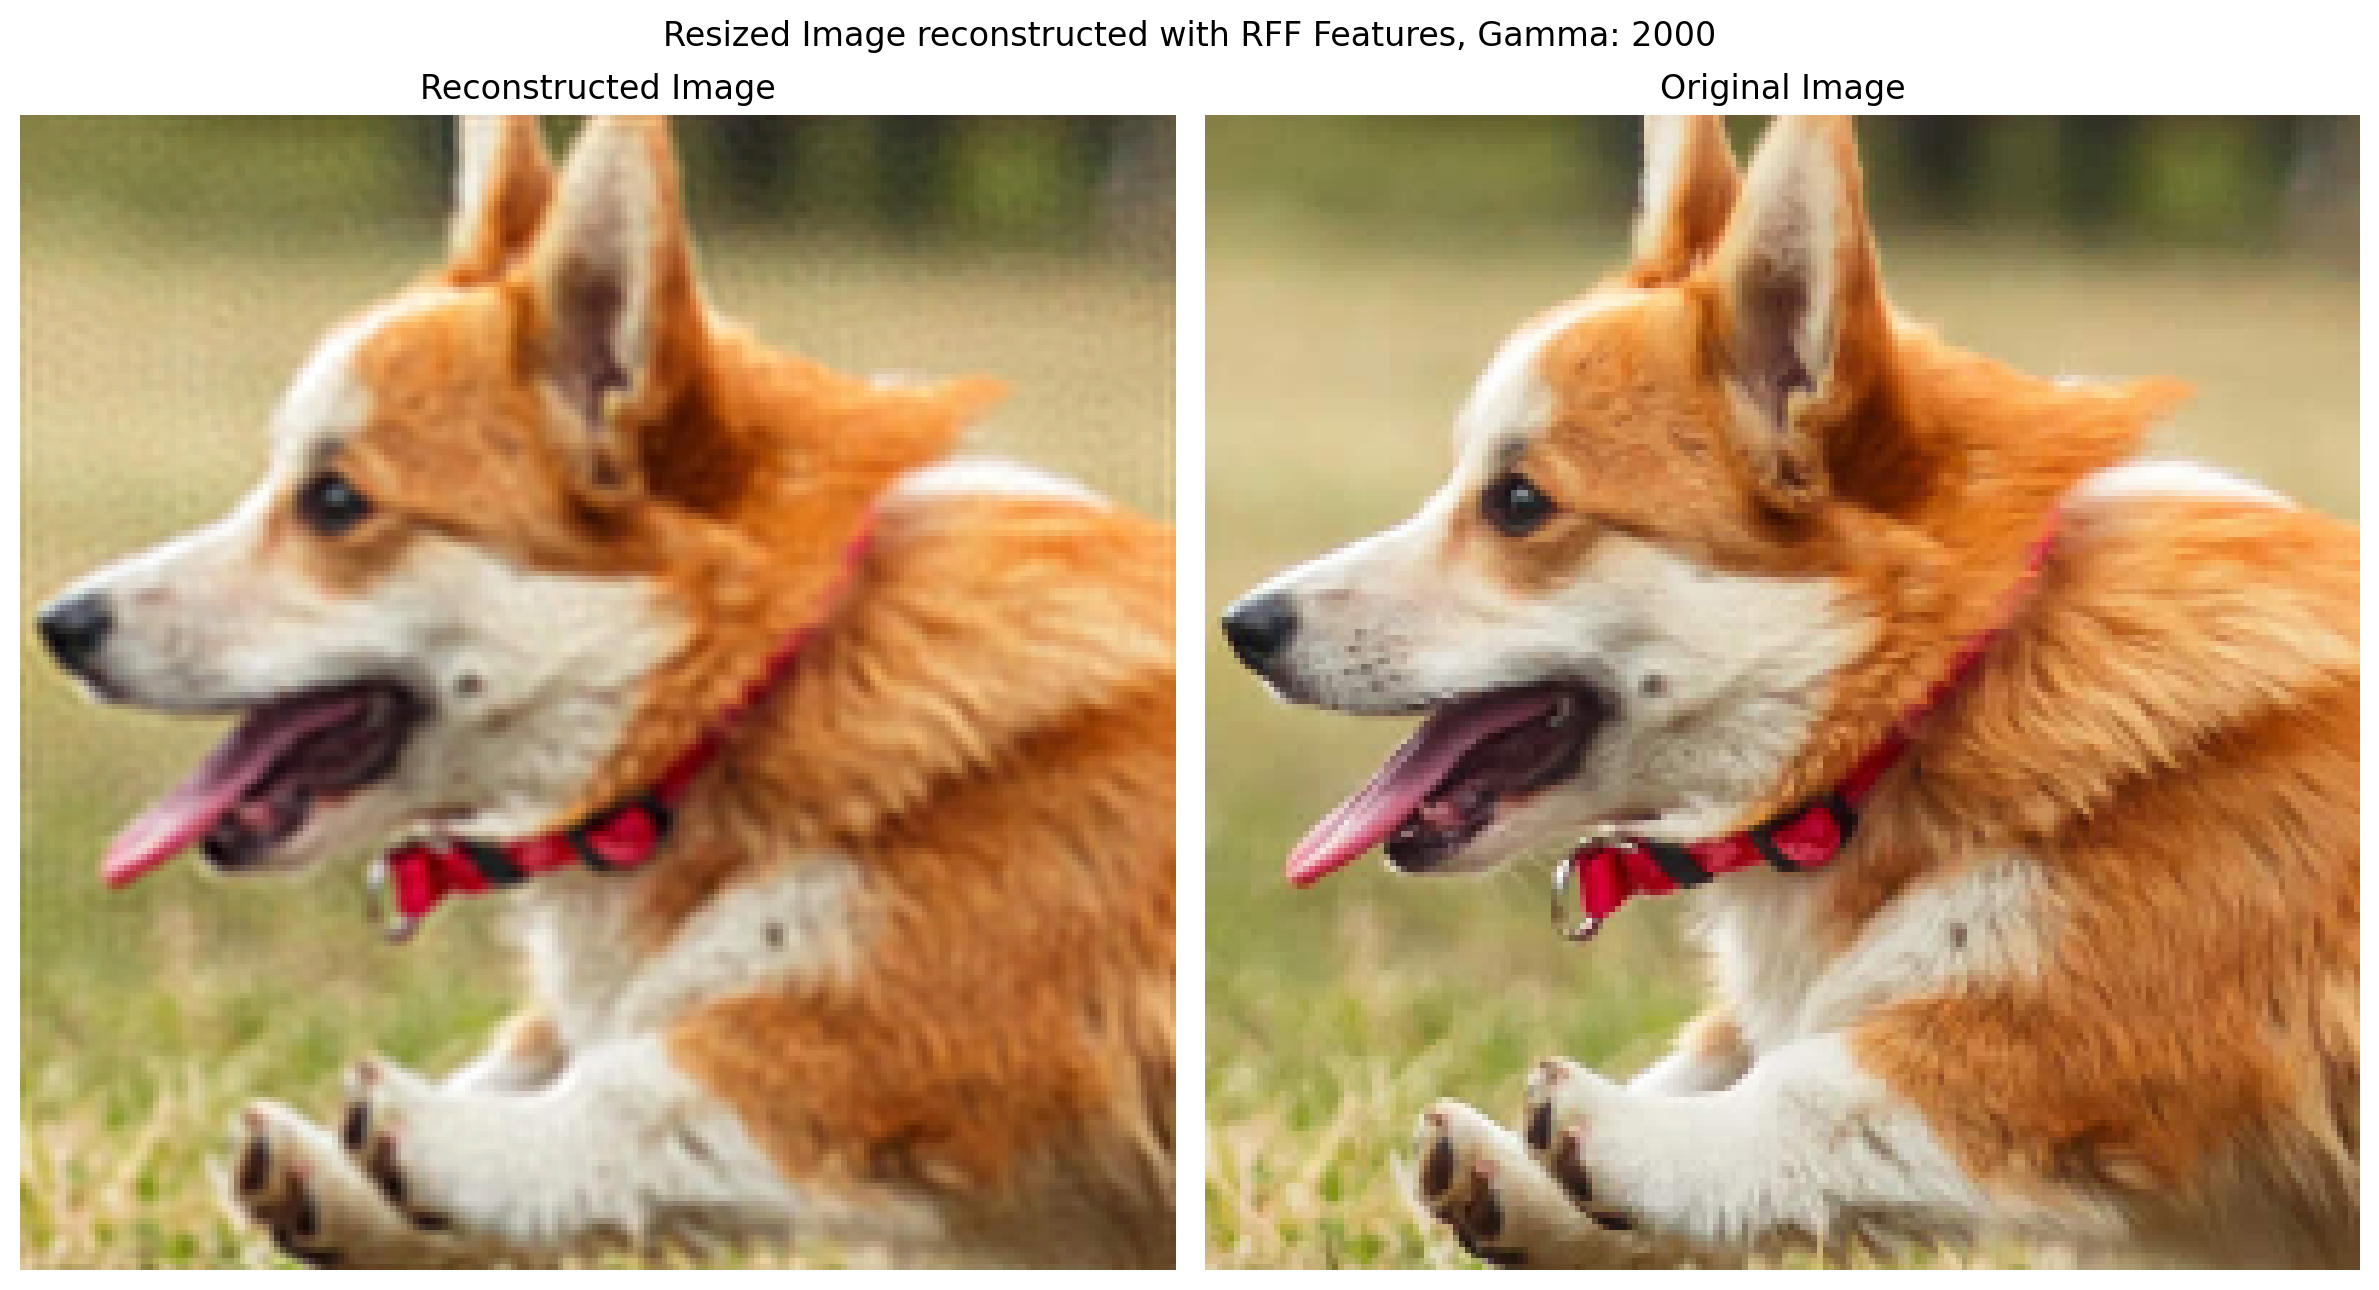

In [16]:
for gamma in [1000, 1500, 2000]:
  X_rff = create_rff_features(dog_X_scaled, 30000, gamma, random_state = 42) # num_of_features = 37500, gamma = 0.008
  net = LinearModel(X_rff.shape[1], 3)
  net.to(device)
  train(net, 0.001, X_rff, dog_Y, 2500)
  torch.cuda.empty_cache()
  plot_reconstructed_and_original_image(resized_image, net, X_rff, f'Resized Image reconstructed with RFF Features, Gamma: {gamma}', scale=1)